In this notebook, we reference the test_predictions.csv (containing probabilities and truth values) to perform debiasing analysis and see if we have succeeded in debiasing the original results 

## Initial setup

### Library Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading

In [3]:
df = pd.read_csv("../test_predictions.csv")
df.head()

,subject_id,study_id,Enlarged Cardiomediastinum_ground_truth,Cardiomegaly_ground_truth,Lung Opacity_ground_truth,Lung Lesion_ground_truth,Edema_ground_truth,Consolidation_ground_truth,Pneumonia_ground_truth,Atelectasis_ground_truth,...,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,10001176,tensor(53186264),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
1,10001176,tensor(54684191),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
2,10001176,tensor(54684191),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicare,ENGLISH,MARRIED,WHITE,2186-11-28 21:34:00,2186-11-29 05:01:00,0
3,10001217,tensor(52067803),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,DIRECT EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0
4,10001217,tensor(58913004),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,DIRECT EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,?,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0


In [4]:
# list of all column labels from dataset
labels = ["Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"]

def get_label_data(df, label):
    y_true = df[f"{label}_ground_truth"]                            # adding "groud_truth" suffix
    y_prob = df[f"{label}_probability"]                             # adding "probability" suffix
    return y_true, y_prob

def find_best_threshold( y_true, y_prob):
    thresholds = np.linspace(0, 1, 100)                            # test 100 thresholds between 0.0. and 1.0
    best_threshold = 0
    best_f1 = 0
    f1_scores = []

    for threshold in thresholds:                                    # threshold used to get the predictions later ( if anything >= threshold, prediction = 1, else 0)
        y_pred = []
        for prob in y_prob:
            # convert probabilities to binary predictions
            if prob >= threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        # f1 score for current threshold
        f1 = f1_score(y_true, y_pred, zero_division = 0)
        f1_scores.append(f1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# process all labels to find the best one for each
def process_all_labels(df, labels):
    results = {}
    for label in labels:
        print(f"Processing Label: {label}")
        y_true, y_prob = get_label_data(df, label)                                              # get ground truth and predicted probabilites for the label
        
        print("Truth Sample:", y_true.head().tolist())
        print("Prob Sampe: ", y_prob.head().tolist())

        best_threshold, best_f1 = find_best_threshold(y_true, y_prob)                           # find best threshold and f1 score
        results[label] = {"best_threshold": best_threshold, "best_f1": best_f1}
    
        print("\n----------")
        print(f"Best Threshold For Label '{label}' Based On F1 Score: {best_threshold}")
        print(f"Best F1 Score Overall: {best_f1}")

    return results 

results = process_all_labels(df, labels)

Processing Label: Enlarged Cardiomediastinum
Truth Sample: [0.0, 0.0, 0.0, 0.0, 0.0]
Prob Sampe:  [0.0036931073, 0.03044225, 0.03842152, 0.0035678549, 0.021347234]

----------
Best Threshold For Label 'Enlarged Cardiomediastinum' Based On F1 Score: 0.06060606060606061
Best F1 Score Overall: 0.14543028685790527
Processing Label: Cardiomegaly
Truth Sample: [0.0, 0.0, 0.0, 0.0, 1.0]
Prob Sampe:  [0.06638442, 0.30547863, 0.42899996, 0.015975822, 0.07945464]

----------
Best Threshold For Label 'Cardiomegaly' Based On F1 Score: 0.26262626262626265
Best F1 Score Overall: 0.5203361344537815
Processing Label: Lung Opacity
Truth Sample: [1.0, 0.0, 0.0, 0.0, 0.0]
Prob Sampe:  [0.07572446, 0.30485582, 0.32503587, 0.04631377, 0.04114988]

----------
Best Threshold For Label 'Lung Opacity' Based On F1 Score: 0.25252525252525254
Best F1 Score Overall: 0.512784490025288
Processing Label: Lung Lesion
Truth Sample: [0.0, 0.0, 0.0, 0.0, 0.0]
Prob Sampe:  [0.0040010763, 0.012585873, 0.014311152, 0.009203

### Generate Predictions and Evaluate

Computes standard classification metrics based on given/passed in threshold

In [5]:
def evaluate_metrics(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)                                      # convert probabilites into binary 
    
    return{"Accuracy: ": accuracy_score(y_true, y_pred), "Precision: ": precision_score(y_true, y_pred, zero_division = 0), "Recall: ": recall_score(y_true, y_pred, zero_division = 0), "F1 Score: ": f1_score(y_true, y_pred, zero_division = 0)}


y_true, y_prob = get_label_data(df, "No Finding")                                   # exract ground truth and probability values for 'No Finding' label
best_threshold, best_f1 = find_best_threshold(y_true, y_prob)                       # find best threshold for it
metrics = evaluate_metrics(y_true, y_prob, best_threshold)                          # evaluate metrics at the best threshold
y_pred = (y_prob >= best_threshold).astype(int)                                     # generate binary predictions - used later for FPR and plotting

print("\n---------- METRICS -------------")
for metric, value in metrics.items():
    print(f"{metric.capitalize()}: {value}")
print("--------------------------------")


---------- METRICS -------------
Accuracy: : 0.8058450280209346
Precision: : 0.6651976832032234
Recall: : 0.7750880281690141
F1 score: : 0.7159506708226047
--------------------------------


### Calculate FPR for 'No Finding' Label

Calculate FPR for previously defined label

In [6]:
def calculate_fpr(y_true, y_pred):
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_pred).ravel()
    if(false_positive + true_negative) > 0:
        false_positive_rate = false_positive / (false_positive + true_negative)  
    else: false_positive_rate = 0
    
    print(f"False Positive Rate (FPR) for 'No Finding' Label: ", false_positive_rate)
    return false_positive_rate

fpr = calculate_fpr(y_true, y_pred)

False Positive Rate (FPR) for 'No Finding' Label:  0.17996615905245347


### Plotting FPR Across Demographics


--- Group: F ---
Total in group: 9678
True class distribution: {0.0: 6329, 1.0: 3349}
Predicted class distribution: {0: 5631, 1: 4047}
Best threshold for 'No Finding': 0.333
False Positive Rate (FPR) for 'No Finding' Label:  0.20445568020224364
Stored FPR for gorup F:0.20445568020224364

--- Group: M ---
Total in group: 11913
True class distribution: {0.0: 8446, 1.0: 3467}
Predicted class distribution: {0: 8018, 1: 3895}
Best threshold for 'No Finding': 0.333
False Positive Rate (FPR) for 'No Finding' Label:  0.16161496566421976
Stored FPR for gorup M:0.16161496566421976
Returned FPRs: {'F': 0.20445568020224364, 'M': 0.16161496566421976}

Filtered:  <class 'dict'> {'F': 0.20445568020224364, 'M': 0.16161496566421976}
Raw FPRs: {'F': 0.20445568020224364, 'M': 0.16161496566421976}
Filtered: {'F': 0.20445568020224364, 'M': 0.16161496566421976}


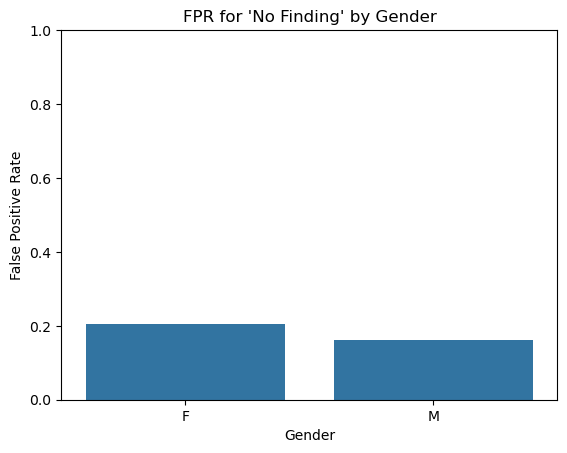

In [7]:
def calculate_fpr_by_grouped(df, label, group_column):
    fprs = {}
    y_true, y_prob = get_label_data(df, label)                                                  # extract ground truth and predictions for the label 
    best_threshold, _ = find_best_threshold(y_true, y_prob)                                     # find best threshold for converting probabilities to binary 
    y_pred = (y_prob >= best_threshold).astype(int)

    # temporary df for predictions and ground truth
    temp_df = df.copy()
    temp_df["true_class"] = y_true
    temp_df["pred_class"] = y_pred

    for group in temp_df[group_column].dropna().unique():                                       # loop through each unique group value e.g M and F in Gender
        group_subset = temp_df[temp_df[group_column] == group]
        
        print(f"\n--- Group: {group} ---")
        print("Total in group:", len(group_subset))
        print("True class distribution:", group_subset["true_class"].value_counts().to_dict())
        print("Predicted class distribution:", group_subset["pred_class"].value_counts().to_dict())
        print(f"Best threshold for '{label}': {best_threshold:.3f}")

        if group_subset["pred_class"].nunique() < 2 or group_subset["true_class"].nunique() < 2:        # check if there is enough varying data 
            print(f"Skipping group {group} since theres not enough varying data")
            fpr[group] = None   
        else:
            fpr = calculate_fpr(group_subset["true_class"], group_subset["pred_class"])                 # calculate FPR 
            fprs[group]= fpr
            print(f"Stored FPR for gorup {group}:{fprs[group]}")
    print(f"Returned FPRs:", fprs)
    return fprs

# specify label and group column
label = "No Finding"
group_column = "gender"

# calls the group-based FPR 
fprs_by_gender = calculate_fpr_by_grouped(df, label, group_column)

# filter any Noneo or NaN values
filtered_fprs = {}
for key, value in fprs_by_gender.items():
    if value is not None and not np.isnan(value):
        filtered_fprs[key] = value

print("\nFiltered: ", type(filtered_fprs), filtered_fprs)
print("Raw FPRs:", fprs_by_gender)
print("Filtered:", filtered_fprs)

# --- Plotting ---
# only if there are valid entries
if filtered_fprs:
    sns.barplot(x = list(filtered_fprs.keys()), y = list(filtered_fprs.values()))
    plt.title(f"FPR for '{label}' by {group_column.capitalize()}")
    plt.ylabel("False Positive Rate")
    plt.xlabel(group_column.capitalize())
    # plt.legend()
    plt.ylim(0, 1)
    plt.show()
else:
    print("No valid FPR To Plot!")

In [8]:
print(fprs_by_gender)

{'F': 0.20445568020224364, 'M': 0.16161496566421976}


In [9]:
print(df["No Finding_ground_truth"].value_counts())
print(df["No Finding_probability"].describe())

No Finding_ground_truth
0.0    14775
1.0     6816
Name: count, dtype: int64
count    21591.000000
mean         0.315150
std          0.296991
min          0.005754
25%          0.071816
50%          0.165774
75%          0.552687
max          0.968020
Name: No Finding_probability, dtype: float64


## Calculate TPR gaps for the sensitive attributes (gender, race, insurance)

In [11]:
def calculate_tpr(y_true, y_pred):
    
    #Calculate True Positive Rate (TPR) for a given set of true labels and predictions.
    
    true_positive, false_negative = confusion_matrix(y_true, y_pred).ravel()[-2:]
    if (true_positive + false_negative) > 0:
        tpr = true_positive / (true_positive + false_negative)
    else:
        tpr = 0
    return tpr

def calculate_tpr_by_grouped(df, label, group_column):
    
    #Calculate TPR 
    
    tprs = {}
    y_true, y_prob = get_label_data(df, label)  # Extract ground truth and probabilities for the label
    best_threshold, _ = find_best_threshold(y_true, y_prob)  # Find the best threshold
    y_pred = (y_prob >= best_threshold).astype(int)  # Generate binary predictions

    # Create a temporary DataFrame for group-based analysis
    temp_df = df.copy()
    temp_df["true_class"] = y_true
    temp_df["pred_class"] = y_pred

    for group in temp_df[group_column].dropna().unique():  # Loop through each unique group
        group_subset = temp_df[temp_df[group_column] == group]
        print(f"\n--- Group: {group} ---")
        print("Total in group:", len(group_subset))
        print("True class distribution:", group_subset["true_class"].value_counts().to_dict())
        print("Predicted class distribution:", group_subset["pred_class"].value_counts().to_dict())
        print(f"Best threshold for '{label}': {best_threshold:.3f}")

        if group_subset["pred_class"].nunique() < 2 or group_subset["true_class"].nunique() < 2:
            print(f"Skipping group {group} since there's not enough varying data")
            tprs[group] = None
        else:
            tpr = calculate_tpr(group_subset["true_class"], group_subset["pred_class"])
            tprs[group] = tpr
            print(f"Stored TPR for group {group}: {tprs[group]}")

    print(f"Returned TPRs: {tprs}")
    return tprs

def calculate_tpr_gap(tprs):

    #Calculate the TPR gap (difference between max and min TPR) for a given set of TPRs.
    
    valid_tprs = [tpr for tpr in tprs.values() if tpr is not None]
    if valid_tprs:
        tpr_gap = max(valid_tprs) - min(valid_tprs)
    else:
        tpr_gap = None
    return tpr_gap

# Specify the label and demographic columns
label = "No Finding"

# Calculate TPR by gender
tprs_by_gender = calculate_tpr_by_grouped(df, label, "gender")
tpr_gap_gender = calculate_tpr_gap(tprs_by_gender)
print(f"\nTPR Gap for Gender: {tpr_gap_gender}")

# Calculate TPR by insurance
tprs_by_insurance = calculate_tpr_by_grouped(df, label, "insurance")
tpr_gap_insurance = calculate_tpr_gap(tprs_by_insurance)
print(f"\nTPR Gap for Insurance: {tpr_gap_insurance}")

# Calculate TPR by race
tprs_by_race = calculate_tpr_by_grouped(df, label, "ethnicity")
tpr_gap_race = calculate_tpr_gap(tprs_by_race)
print(f"\nTPR Gap for Race: {tpr_gap_race}")


--- Group: F ---
Total in group: 9678
True class distribution: {0.0: 6329, 1.0: 3349}
Predicted class distribution: {0: 5631, 1: 4047}
Best threshold for 'No Finding': 0.333
Stored TPR for group F: 0.17796357121528814

--- Group: M ---
Total in group: 11913
True class distribution: {0.0: 8446, 1.0: 3467}
Predicted class distribution: {0: 8018, 1: 3895}
Best threshold for 'No Finding': 0.333
Stored TPR for group M: 0.2702624747620421
Returned TPRs: {'F': 0.17796357121528814, 'M': 0.2702624747620421}

TPR Gap for Gender: 0.09229890354675399

--- Group: Medicare ---
Total in group: 10528
True class distribution: {0.0: 7755, 1.0: 2773}
Predicted class distribution: {0: 7309, 1: 3219}
Best threshold for 'No Finding': 0.333
Stored TPR for group Medicare: 0.29138117562206994

--- Group: Other ---
Total in group: 9416
True class distribution: {0.0: 5960, 1.0: 3456}
Predicted class distribution: {0: 5354, 1: 4062}
Best threshold for 'No Finding': 0.333
Stored TPR for group Other: 0.17766203703

## Plot the TPR gap results

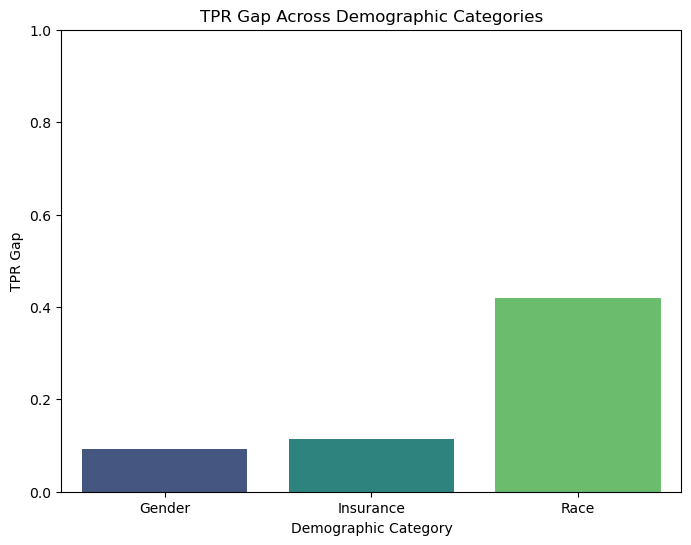

In [12]:
def plot_tpr_gaps(tpr_gaps, demographic_categories):
    """
    Plot TPR gaps for different demographic categories.

    Parameters:
    - tpr_gaps: Dictionary containing TPR gaps for each demographic category.
    - demographic_categories: List of demographic categories (e.g., gender, insurance, race).
    """
    # Convert the TPR gaps into a DataFrame
    tpr_gap_df = pd.DataFrame({
        "Demographic Category": demographic_categories,
        "TPR Gap": [tpr_gaps[category] for category in demographic_categories]
    })

    # Plot the TPR gaps
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x="Demographic Category",
        y="TPR Gap",
        hue="Demographic Category",  
        data=tpr_gap_df,
        palette="viridis",
        dodge=False,  
        legend=False  
    )
    plt.title("TPR Gap Across Demographic Categories")
    plt.ylabel("TPR Gap")
    plt.xlabel("Demographic Category")
    plt.ylim(0, 1)  # TPR gaps are between 0 and 1
    plt.show()


# Store the TPR gaps in a dict
tpr_gaps = {
    "Gender": tpr_gap_gender,
    "Insurance": tpr_gap_insurance,
    "Race": tpr_gap_race
}

# Plot the TPR gaps
plot_tpr_gaps(tpr_gaps, ["Gender", "Insurance", "Race"])